This notebook evaluates GNNs for 'is_planar' task. The dataset is synthetic and based on `torch_geometric.datasets.FakeDataset` in following settings:
* node features: one hot degree; dataset: avg_degree=4, avg_num_nodes=8
  * GNNs: GCN, SAGE, Conv (see `src/models`)
  * NNs: input - sum of node features (no edges), 4 hidden layers.
* node features: constant; identical graph dataset;
  * GNNs: GCN, SAGE, Conv

The number of graphs is each dataset is 1mln.

# Results:

Legend:
* F1: the value of the test F1 score after 100 epoch
* F1 10: mean F1 score over the last 10 epoches (91-100)
* Accuracy: the value of Accuracy score after 100 epoch
* One hot 8: num nodes = 8, avg degree = 4, size = 1mln, one hot degree features with 11 elements; 216652 positives.
* Const 8:   num nodes = 8, avg degree = 4, size = 1mln, one constant node feature = 1.0; 216652 positives.
* Baseline: A simple non-GNN model with 4 hidden dense layers and 100 hidden channels. Input: sum of node features, no edges given.
* SAGE-5 and SAGE-10: SAGE arch with 5 and 10 convolutional layers correspondingly.
* SAGE-3-20: SAGE arch with 3 convolutional layers and 20 hidden channels.

    
| Dataset | Model  | Test F1 | Test F1 10 | Test Accuracy | Train F1 | Train Accuracy |
|---|---|---|---|---|---|---|
| One hot 8 | Baseline | 0.862  | 0.853 | 0.943 | 0.863 | 0.943 |
| One hot 8 | GCN      | 0.929  | 0.931 | 0.969 | 0.931 | 0.970 |
| One hot 8 | SAGE     | **0.964** | 0.966 | **0.985** | 0.964 | 0.985 |
| One hot 8 | Conv     | 0.957 | 0.956 | 0.982 | 0.958 | 0.982 |
| One hot 8 | SAGE-5   | 0.869 | 0.887 | 0.947 | 0.870 | 0.947 |
| One hot 8 | SAGE-3-20| 0.880 | 0.890 | 0.943 | 0.881 | 0.943 |
| One hot 8 | SAGE-4   | 0.860 | 0.883 | 0.932 | 0.861 | 0.932 |

| Dataset | Model  | Test F1 | Test F1 10 | Test Accuracy | Train F1 | Train Accuracy |
|---|---|---|---|---|---|---|
| Const 8 | GCN  | 0     | 0     | 0.783 | 0 | 0.783 |
| Const 8 | SAGE | 0     | 0     | 0.783 | 0 | 0.783 |
| Const 8 | Conv | 0.877 | 0.869 | 0.944 | 0.878 | 0.9450


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import FakeDatasetIsPlanar, split_dataset
from visualization import visualize
from model import GCN, SAGE, ConvGNN, CustomSAGE
from training.train_eval import TrainEval
from training.train_eval_graphless import TrainEvalGraphless

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import OneHotDegree, Constant
from torch_geometric.datasets import FakeDataset
from torch_geometric.nn import GCNConv
from torch import nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import torch
import random
import numpy as np


In [3]:
NUM_GRAPHS = 1000000
NUM_EPOCH = 100

# Features: one hot degree, avg_nodes: 8

## GNNs

In [4]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

one_hot_degree = OneHotDegree(max_degree, cat=False)

ds_onehot_8 = FakeDatasetIsPlanar(num_graphs=NUM_GRAPHS, avg_num_nodes=8, avg_degree=avg_degree,
                               transform=one_hot_degree)
print(f"Planar graphs: {int(ds_onehot_8.y.sum())}")
ds_onehot_8

Planar graphs: 216652
CPU times: user 3min 57s, sys: 2.59 s, total: 3min 59s
Wall time: 4min 2s


FakeDatasetIsPlanar(1000000)

In [5]:
ds_onehot_8[0]

Data(edge_index=[2, 50], y=[1], is_planar=[1], pos=[10, 2], num_nodes=10, x=[10, 11])

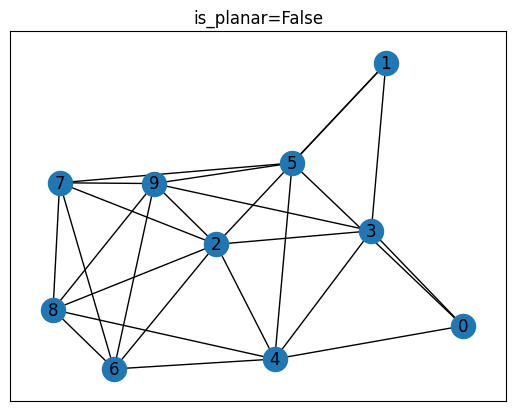

In [6]:
visualize(ds_onehot_8[0])

In [7]:
onehot_8_train_loader, onehot_8_test_loader = split_dataset(ds_onehot_8)

Number of training graphs: 800000
Number of test graphs: 200000


GCN(
  (conv1): GCNConv(11, 11)
  (conv2): GCNConv(11, 11)
  (conv3): GCNConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9626, precision=0.9336, recall=0.8908, size=800000.0000, f1=0.9117, Test: accuracy=0.9624, precision=0.9320, recall=0.8910, size=200000.0000, f1=0.9110
Epoch:  02, Train: accuracy=0.9637, precision=0.9273, recall=0.9032, size=800000.0000, f1=0.9151, Test: accuracy=0.9634, precision=0.9266, recall=0.9023, size=200000.0000, f1=0.9143
Epoch:  03, Train: accuracy=0.9658, precision=0.9219, recall=0.9200, size=800000.0000, f1=0.9210, Test: accuracy=0.9657, precision=0.9212, recall=0.9202, size=200000.0000, f1=0.9207
Epoch:  04, Train: accuracy=0.9659, precision=0.9325, recall=0.9085, size=800000.0000, f1=0.9203, Test: accuracy=0.9655, precision=0.9314, recall=0.9070, size=200000.0000, f1=0.9191
Epoch:  05, Train: accuracy=0.9653, precision=0.9351, recall=0.9027, size=800000.0000, f1=0.9186, Test: accuracy=0.9651, prec

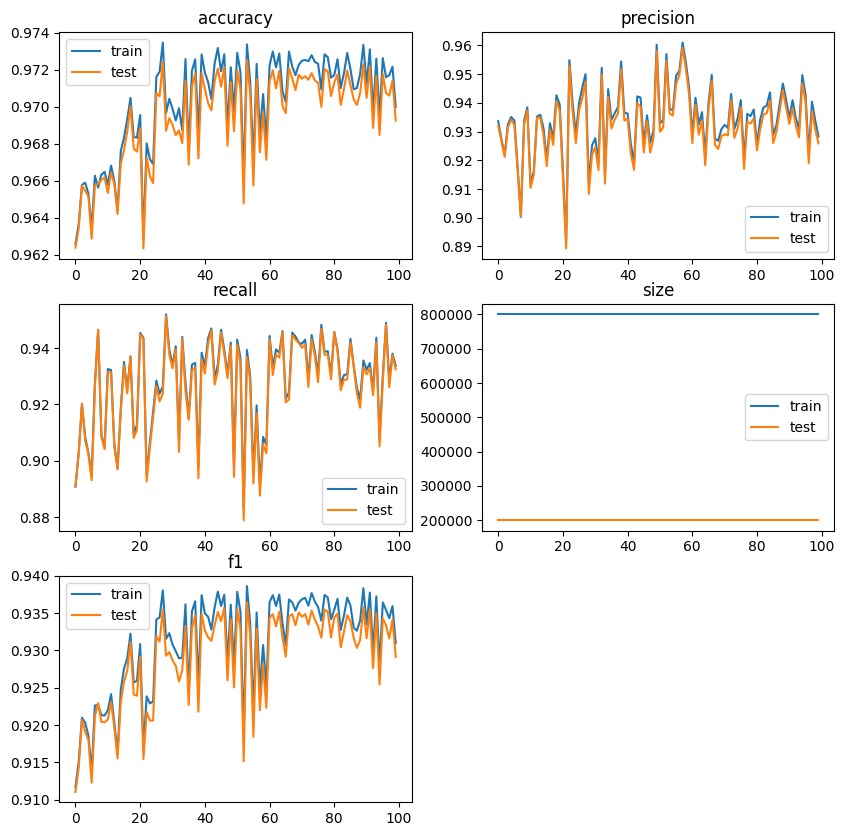

In [23]:
gcn_model = GCN(hidden_channels=11, num_node_features=ds_onehot_8.num_node_features,
            num_classes=ds_onehot_8.num_classes)
print(gcn_model)

te = TrainEval(gcn_model)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

SAGE(
  (conv1): SAGEConv(11, 11, aggr=mean)
  (conv2): SAGEConv(11, 11, aggr=mean)
  (conv3): SAGEConv(11, 11, aggr=mean)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9785, precision=0.9708, recall=0.9288, size=800000.0000, f1=0.9493, Test: accuracy=0.9782, precision=0.9698, recall=0.9278, size=200000.0000, f1=0.9484
Epoch:  02, Train: accuracy=0.9790, precision=0.9507, recall=0.9527, size=800000.0000, f1=0.9517, Test: accuracy=0.9786, precision=0.9487, recall=0.9526, size=200000.0000, f1=0.9506
Epoch:  03, Train: accuracy=0.9822, precision=0.9591, recall=0.9587, size=800000.0000, f1=0.9589, Test: accuracy=0.9821, precision=0.9577, recall=0.9594, size=200000.0000, f1=0.9586
Epoch:  04, Train: accuracy=0.9826, precision=0.9711, recall=0.9479, size=800000.0000, f1=0.9594, Test: accuracy=0.9826, precision=0.9707, recall=0.9478, size=200000.0000, f1=0.9592
Epoch:  05, Train: accuracy=0.9801, precision=0.9810, recall=0.9263, size=800000.0000, f

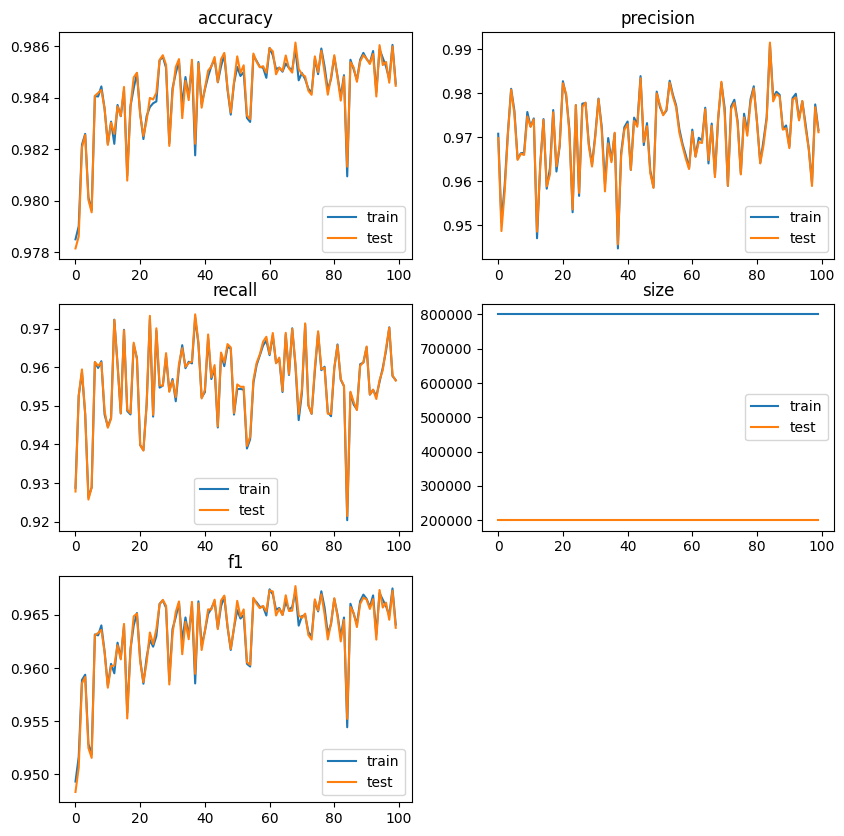

In [24]:
sage_model = SAGE(hidden_channels=11, num_node_features=ds_onehot_8.num_node_features,
                  num_classes=ds_onehot_8.num_classes)
print(sage_model)

te = TrainEval(sage_model)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

ConvGNN(
  (conv1): GraphConv(11, 11)
  (conv2): GraphConv(11, 11)
  (conv3): GraphConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9781, precision=0.9619, recall=0.9362, size=800000.0000, f1=0.9489, Test: accuracy=0.9778, precision=0.9604, recall=0.9357, size=200000.0000, f1=0.9479
Epoch:  02, Train: accuracy=0.9775, precision=0.9634, recall=0.9315, size=800000.0000, f1=0.9472, Test: accuracy=0.9772, precision=0.9622, recall=0.9313, size=200000.0000, f1=0.9465
Epoch:  03, Train: accuracy=0.9774, precision=0.9338, recall=0.9639, size=800000.0000, f1=0.9486, Test: accuracy=0.9773, precision=0.9334, recall=0.9637, size=200000.0000, f1=0.9483
Epoch:  04, Train: accuracy=0.9798, precision=0.9649, recall=0.9411, size=800000.0000, f1=0.9528, Test: accuracy=0.9794, precision=0.9632, recall=0.9408, size=200000.0000, f1=0.9518
Epoch:  05, Train: accuracy=0.9803, precision=0.9722, recall=0.9358, size=800000.0000, f1=0.9537, Test: accuracy=0.

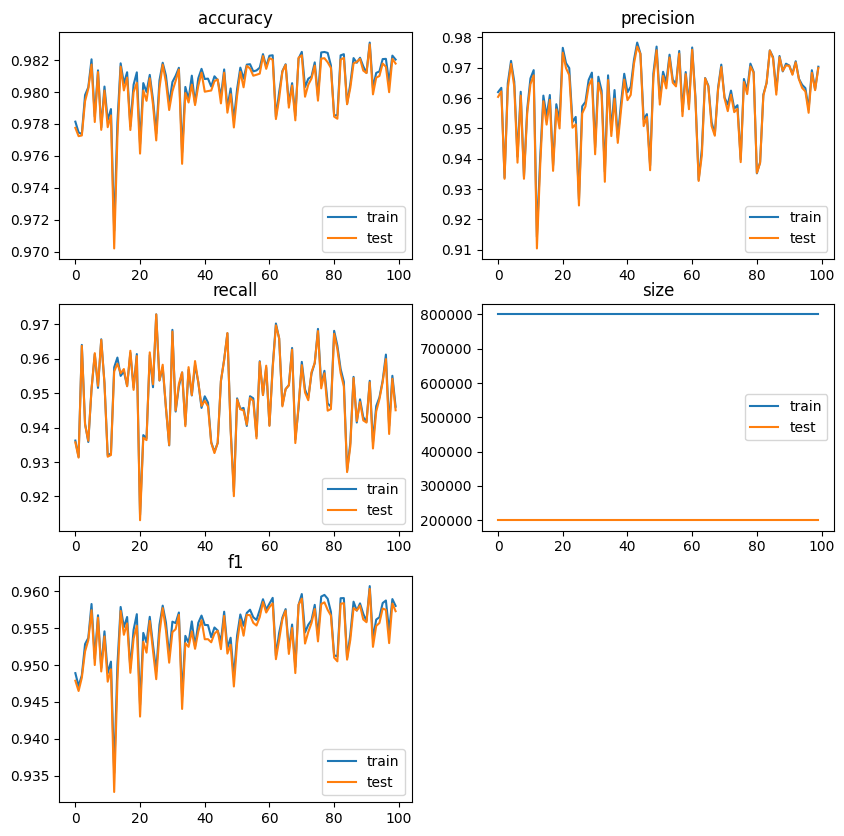

In [40]:
conv_model = ConvGNN(hidden_channels=11, num_node_features=ds_onehot_8.num_node_features,
                     num_classes=2)
print(conv_model)

te = TrainEval(conv_model)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

CustomSAGE(
  (sage): GraphSAGE(11, 11, num_layers=5)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9478, precision=0.8532, recall=0.9171, size=800000.0000, f1=0.8840, Test: accuracy=0.9476, precision=0.8525, recall=0.9160, size=200000.0000, f1=0.8831
Epoch:  02, Train: accuracy=0.9496, precision=0.8965, recall=0.8675, size=800000.0000, f1=0.8818, Test: accuracy=0.9489, precision=0.8953, recall=0.8648, size=200000.0000, f1=0.8798
Epoch:  03, Train: accuracy=0.9516, precision=0.9053, recall=0.8674, size=800000.0000, f1=0.8859, Test: accuracy=0.9515, precision=0.9043, recall=0.8673, size=200000.0000, f1=0.8854
Epoch:  04, Train: accuracy=0.9497, precision=0.8907, recall=0.8756, size=800000.0000, f1=0.8831, Test: accuracy=0.9493, precision=0.8889, recall=0.8747, size=200000.0000, f1=0.8818
Epoch:  05, Train: accuracy=0.9545, precision=0.8954, recall=0.8944, size=800000.0000, f1=0.8949, Test: accuracy=0.9541, precision=0.8945, recall=0.8930, siz

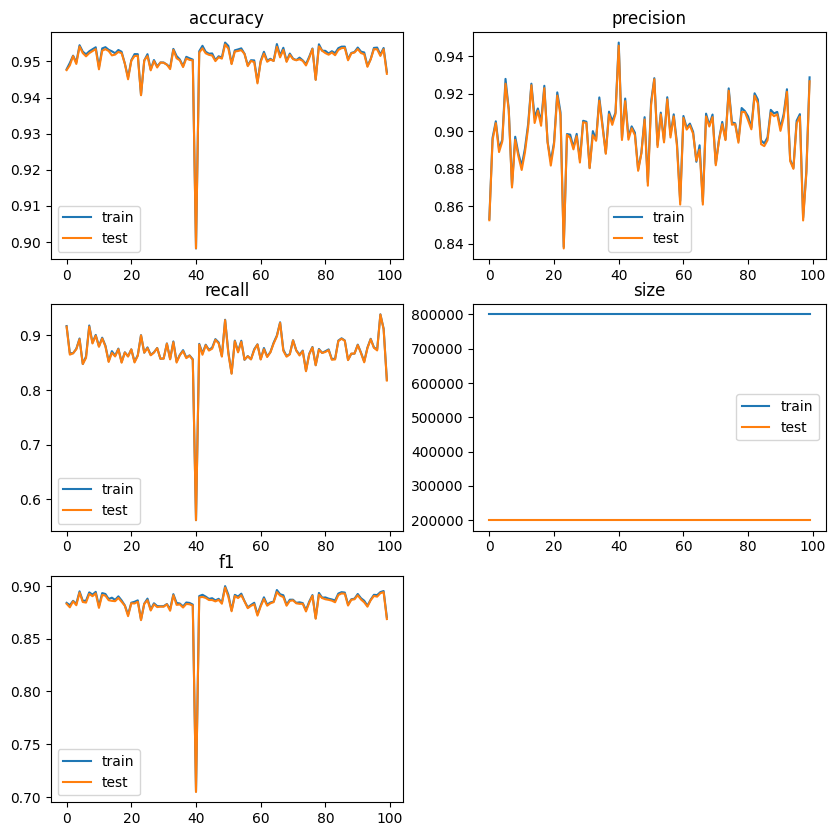

In [8]:
# SAGE with 5 layers

sage_5_model = CustomSAGE(hidden_layers=5, hidden_channels=11, num_node_features=ds_onehot_8.num_node_features,
                          num_classes=2)
print(sage_5_model)

te = TrainEval(sage_5_model)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

CustomSAGE(
  (sage): GraphSAGE(11, 20, num_layers=3)
  (lin): Linear(in_features=20, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9523, precision=0.8609, recall=0.9305, size=800000.0000, f1=0.8943, Test: accuracy=0.9518, precision=0.8595, recall=0.9288, size=200000.0000, f1=0.8928
Epoch:  02, Train: accuracy=0.9161, precision=0.7301, recall=0.9726, size=800000.0000, f1=0.8341, Test: accuracy=0.9162, precision=0.7298, recall=0.9723, size=200000.0000, f1=0.8338
Epoch:  03, Train: accuracy=0.9507, precision=0.8383, recall=0.9572, size=800000.0000, f1=0.8938, Test: accuracy=0.9502, precision=0.8366, recall=0.9562, size=200000.0000, f1=0.8924
Epoch:  04, Train: accuracy=0.9275, precision=0.7557, recall=0.9833, size=800000.0000, f1=0.8546, Test: accuracy=0.9276, precision=0.7556, recall=0.9830, size=200000.0000, f1=0.8544
Epoch:  05, Train: accuracy=0.9292, precision=0.7618, recall=0.9797, size=800000.0000, f1=0.8571, Test: accuracy=0.9298, precision=0.7630, recall=0.9798, siz

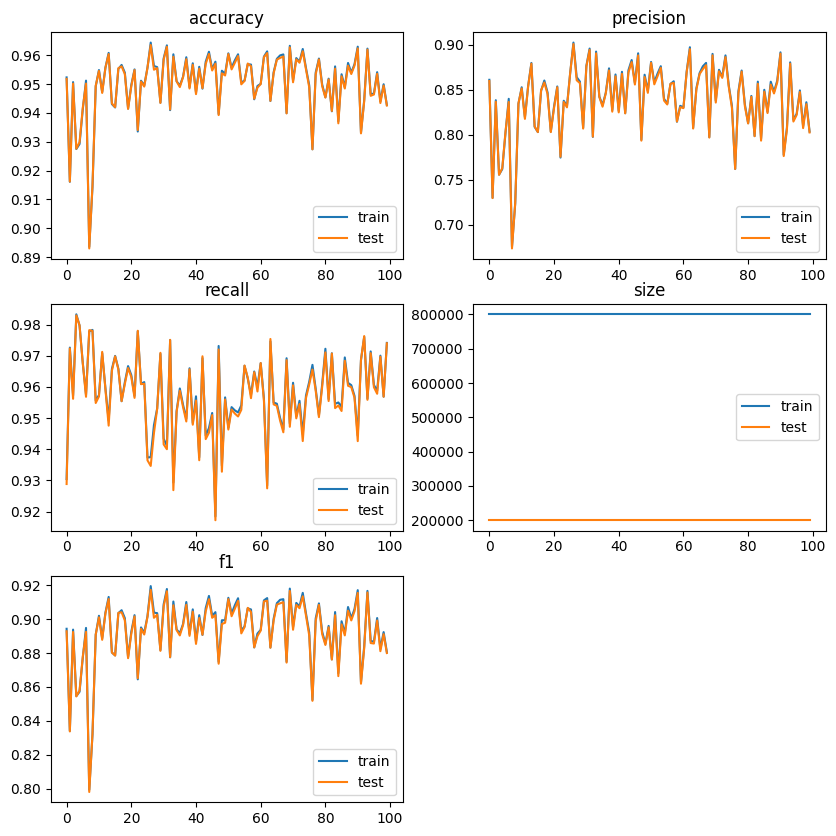

In [9]:
# SAGE with 3 layers but 20 hidden channels 

sage_h20_model = CustomSAGE(hidden_layers=3, hidden_channels=20, num_node_features=ds_onehot_8.num_node_features,
                          num_classes=2)
print(sage_h20_model)

te = TrainEval(sage_h20_model)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

CustomSAGE(
  (sage): GraphSAGE(11, 11, num_layers=4)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9347, precision=0.7873, recall=0.9575, size=800000.0000, f1=0.8641, Test: accuracy=0.9347, precision=0.7871, recall=0.9567, size=200000.0000, f1=0.8637
Epoch:  02, Train: accuracy=0.9458, precision=0.8443, recall=0.9193, size=800000.0000, f1=0.8802, Test: accuracy=0.9456, precision=0.8437, recall=0.9184, size=200000.0000, f1=0.8795
Epoch:  03, Train: accuracy=0.9454, precision=0.8330, recall=0.9356, size=800000.0000, f1=0.8813, Test: accuracy=0.9448, precision=0.8312, recall=0.9344, size=200000.0000, f1=0.8798
Epoch:  04, Train: accuracy=0.9519, precision=0.9008, recall=0.8743, size=800000.0000, f1=0.8873, Test: accuracy=0.9513, precision=0.8979, recall=0.8742, size=200000.0000, f1=0.8859
Epoch:  05, Train: accuracy=0.9511, precision=0.8511, recall=0.9384, size=800000.0000, f1=0.8926, Test: accuracy=0.9504, precision=0.8489, recall=0.9374, siz

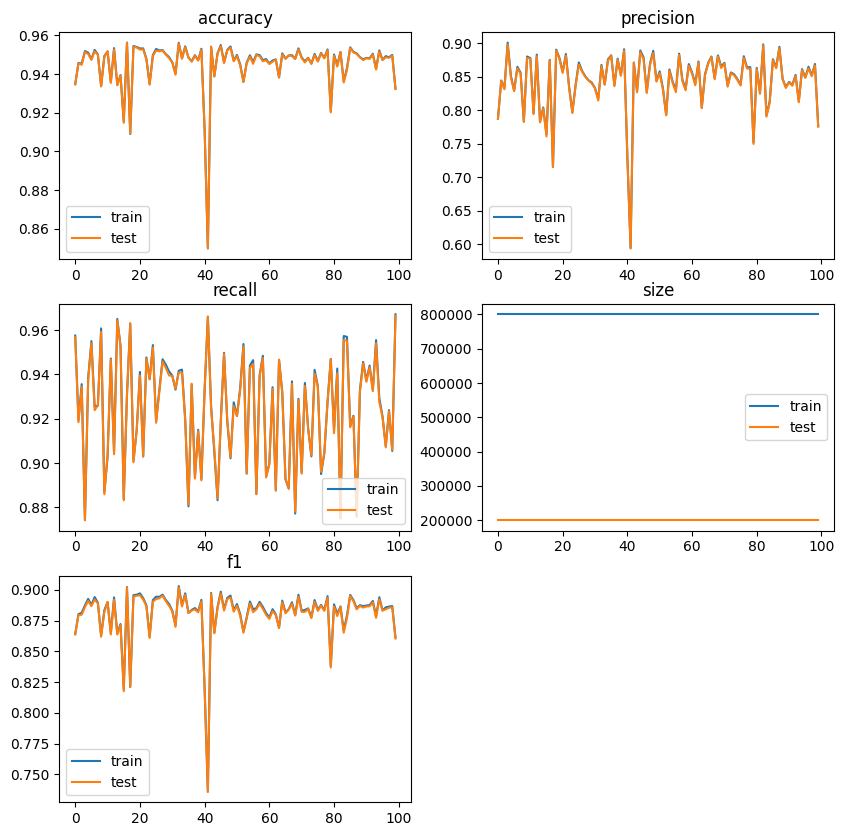

In [10]:
# SAGE with 4 layers

sage_4_model = CustomSAGE(hidden_layers=4, hidden_channels=11, num_node_features=ds_onehot_8.num_node_features,
                          num_classes=2)
print(sage_4_model)

te = TrainEval(sage_4_model)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

## NN

Epoch:  01, Train: accuracy=0.9302, precision=0.9539, recall=0.7125, size=800000.0000, f1=0.8157, Test: accuracy=0.9301, precision=0.9530, recall=0.7117, size=200000.0000, f1=0.8149
Epoch:  02, Train: accuracy=0.9454, precision=0.9069, recall=0.8336, size=800000.0000, f1=0.8687, Test: accuracy=0.9450, precision=0.9058, recall=0.8321, size=200000.0000, f1=0.8674
Epoch:  03, Train: accuracy=0.9464, precision=0.8880, recall=0.8613, size=800000.0000, f1=0.8745, Test: accuracy=0.9461, precision=0.8868, recall=0.8606, size=200000.0000, f1=0.8735
Epoch:  04, Train: accuracy=0.9448, precision=0.8736, recall=0.8712, size=800000.0000, f1=0.8724, Test: accuracy=0.9445, precision=0.8732, recall=0.8692, size=200000.0000, f1=0.8712
Epoch:  05, Train: accuracy=0.9428, precision=0.9183, recall=0.8079, size=800000.0000, f1=0.8595, Test: accuracy=0.9424, precision=0.9180, recall=0.8056, size=200000.0000, f1=0.8581
Epoch:  06, Train: accuracy=0.9460, precision=0.8883, recall=0.8589, size=800000.0000, f1=

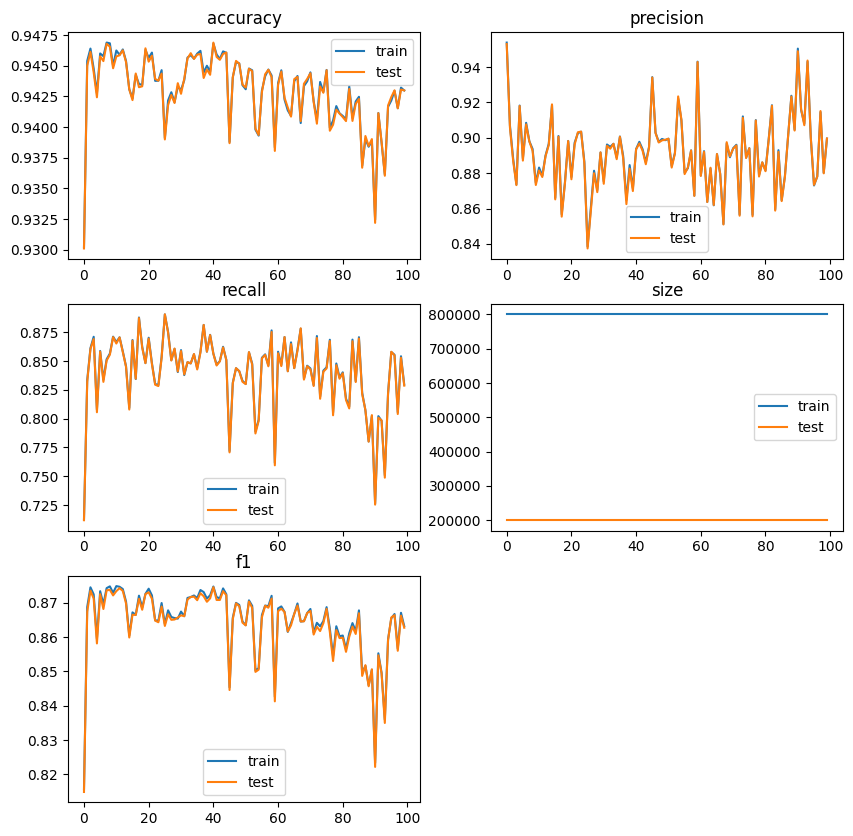

In [12]:
fc_model = nn.Sequential(
    nn.Linear(11, 100),
    nn.ReLU(),
    nn.Linear(100, 1000),
    nn.ReLU(),
    nn.Linear(1000, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
)

te = TrainEvalGraphless(fc_model)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

# Features: constant, avg_nodes: 8

In [ ]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

constant = Constant(value=1.0, cat=False)

ds_const_8 = FakeDatasetIsPlanar(num_graphs=NUM_GRAPHS, avg_num_nodes=8, avg_degree=avg_degree,
                               transform=constant)

print(f"Planar graphs: {int(ds_const_8.y.sum())}")
ds_const_8

In [ ]:
visualize(ds_const_8[0])

In [15]:
ds_const_8_train_loader, ds_const_8_test_loader = split_dataset(ds_const_8)

Number of training graphs: 800000
Number of test graphs: 200000


GCN(
  (conv1): GCNConv(1, 10)
  (conv2): GCNConv(10, 10)
  (conv3): GCNConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  02, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  03, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  04, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  05, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, preci

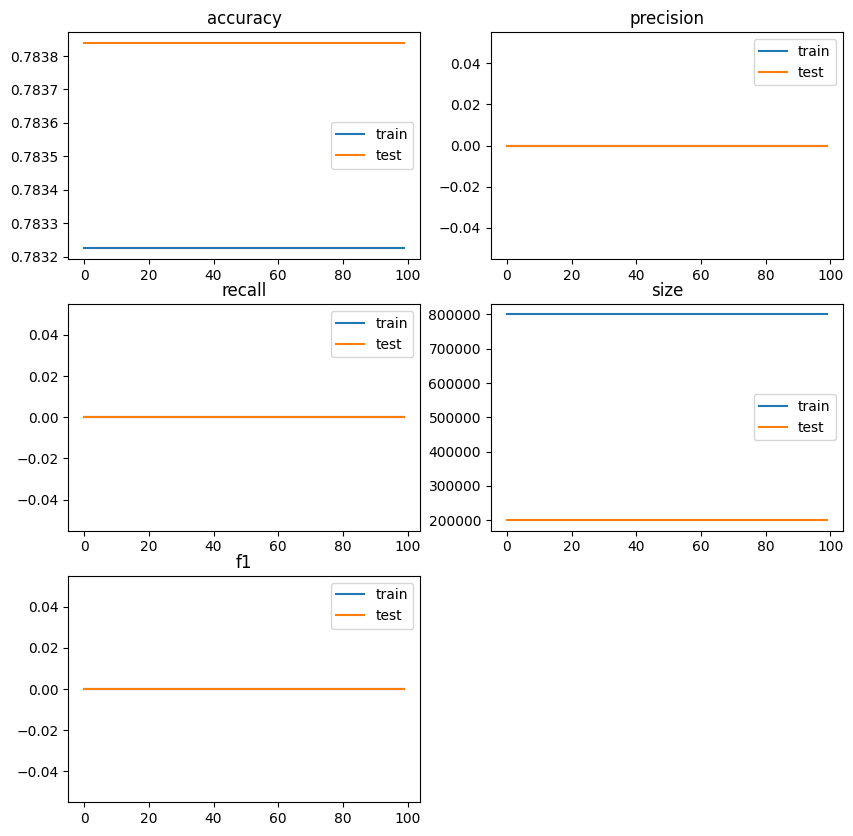

In [16]:
gcn_model = GCN(hidden_channels=10, num_node_features=ds_const_8.num_node_features,
            num_classes=ds_const_8.num_classes)
print(gcn_model)

te = TrainEval(gcn_model)
te.main(NUM_EPOCH, ds_const_8_train_loader, ds_const_8_test_loader)

In [17]:
sage_model = SAGE(hidden_channels=10, num_node_features=ds_const_8.num_node_features,
                  num_classes=ds_const_8.num_classes)
print(sage_model)

te = TrainEval(sage_model)
te.main(NUM_EPOCH, ds_const_8_train_loader, ds_const_8_test_loader)

SAGE(
  (conv1): SAGEConv(1, 10, aggr=mean)
  (conv2): SAGEConv(10, 10, aggr=mean)
  (conv3): SAGEConv(10, 10, aggr=mean)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  02, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  03, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  04, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1=0.0000, Test: accuracy=0.7838, precision=0.0000, recall=0.0000, size=200000.0000, f1=0.0000
Epoch:  05, Train: accuracy=0.7832, precision=0.0000, recall=0.0000, size=800000.0000, f1

KeyboardInterrupt: 

ConvGNN(
  (conv1): GraphConv(1, 10)
  (conv2): GraphConv(10, 10)
  (conv3): GraphConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9397, precision=0.8464, recall=0.8817, size=800000.0000, f1=0.8637, Test: accuracy=0.9396, precision=0.8448, recall=0.8826, size=200000.0000, f1=0.8633
Epoch:  02, Train: accuracy=0.9430, precision=0.8577, recall=0.8838, size=800000.0000, f1=0.8706, Test: accuracy=0.9430, precision=0.8565, recall=0.8846, size=200000.0000, f1=0.8703
Epoch:  03, Train: accuracy=0.9414, precision=0.8653, recall=0.8641, size=800000.0000, f1=0.8647, Test: accuracy=0.9412, precision=0.8634, recall=0.8646, size=200000.0000, f1=0.8640
Epoch:  04, Train: accuracy=0.9367, precision=0.8090, recall=0.9270, size=800000.0000, f1=0.8640, Test: accuracy=0.9361, precision=0.8079, recall=0.9245, size=200000.0000, f1=0.8622
Epoch:  05, Train: accuracy=0.9410, precision=0.8683, recall=0.8581, size=800000.0000, f1=0.8632, Test: accuracy=0.9

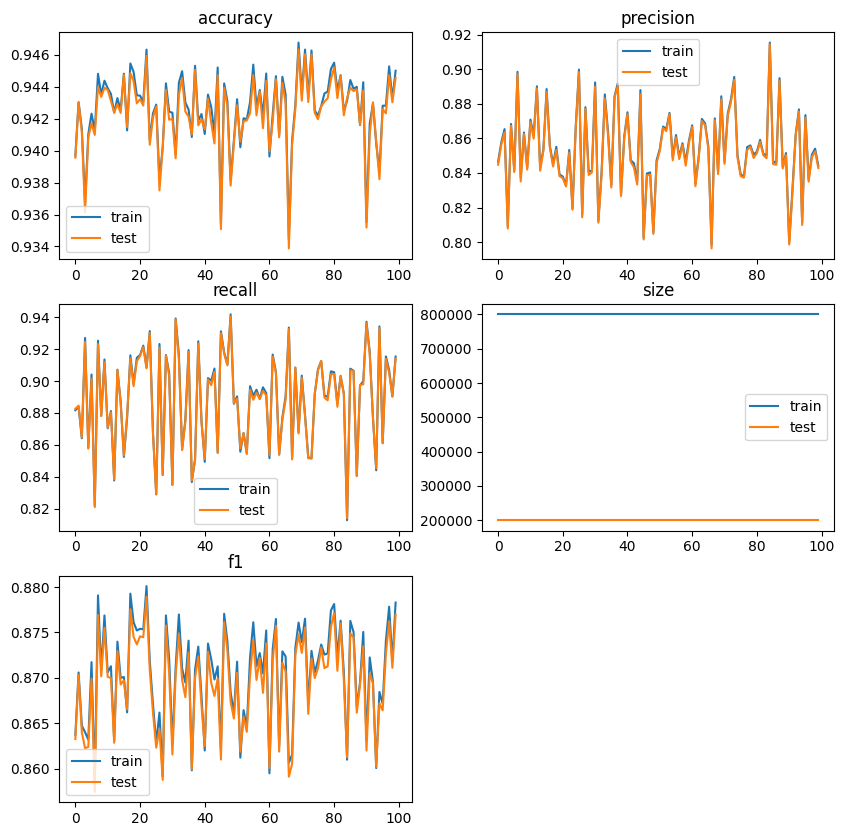

In [18]:
conv_model = ConvGNN(hidden_channels=10, num_node_features=ds_const_8.num_node_features,
                     num_classes=ds_const_8.num_classes)
print(conv_model)

te = TrainEval(conv_model)
te.main(NUM_EPOCH, ds_const_8_train_loader, ds_const_8_test_loader)

# Addon: explain predictions using captum (to be moved into a new notebook)

In [18]:
!conda install captum -c pytorch


^C

CondaError: KeyboardInterrupt



In [ ]:
device = 'cpu'

In [15]:
# the code is copied from PyG tutotial #6 (GNN Explanation) https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing#scrollTo=Z1mJVbKorh5y
# and adopted to simple graphs afterwards

from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict
    

data = random.choice([t for t in test_dataset if not t.y.item()])
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

ModuleNotFoundError: No module named 'captum'

In [17]:
ds_const_8

NameError: name 'ds_const_8' is not defined